In [23]:
# CELL 1: Imports & setup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [24]:
# CELL 2: Load data
df = pd.read_csv("./data/merged4_std_dummy.csv")
print(f"Original shape: {df.shape}")


Original shape: (1299, 64)


In [25]:
# CELL 3: Keep ONLY numeric columns, drop everything else
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
df_numeric = df[numeric_cols].copy()
df_numeric = df_numeric.drop(['isbn','reading_age_preadolescence','reading_age_null'], axis=1)
print(f"Dropped all categorical/text columns")
print(f"Remaining numeric columns: {len(numeric_cols)} → shape: {df_numeric.shape}")
print(f"Columns kept: {list(numeric_cols[:10])}{'...' if len(numeric_cols)>10 else ''}")

Dropped all categorical/text columns
Remaining numeric columns: 62 → shape: (1299, 59)
Columns kept: ['isbn', 'publisher_alligator', 'publisher_amulet_books', 'publisher_autumn', 'publisher_b_e_s_pub_co', 'publisher_bridge_publications,_inc.', 'publisher_cartwheel_books', 'publisher_cornerstone_leadership_institute', 'publisher_creative_teaching_pr', 'publisher_creative_teaching_press']...


In [26]:
# # 1. Drop the obvious one-hot columns that leaked into numeric
# one_hot_leaked = [
#     'book_format_library_binding',
#     'reading_age_preadolescence', 
#     'reading_age_null',
#     'reading_age_preschool'
# ]
# # (add any other reading_age_* or book_format_* you see)

# # 2. Drop or heavily transform the impossible/long-tail ones
# cols_to_drop = one_hot_leaked + ['best_sellers_rank']

# # 3. Log-transform the heavy-tailed physical/price/page columns
# log_transform_cols = ['price', 'width', 'length', 'height', 'print_length']

# df_clean = df_numeric.drop(columns=cols_to_drop, errors='ignore')

# for col in log_transform_cols:
#     if col in df_clean.columns:
#         df_clean[col] = np.sign(df_clean[col]) * np.log1p(np.abs(df_clean[col]))
#         print(f"Log-transformed {col}")

In [27]:
# CELL 4: Simple preprocessing: impute + standardize
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

X = preprocessor.fit_transform(df_numeric)
n_features = X.shape[1]
print(f"Preprocessed numeric data shape: {X.shape}")
print(f"NaNs after imputation: {np.isnan(X).sum()} (should be 0)")

Preprocessed numeric data shape: (1299, 59)
NaNs after imputation: 0 (should be 0)


In [28]:
# CELL 5: PyTorch Dataset
class NumericDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data).to(device)
    
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx], self.data[idx]

dataset = NumericDataset(X)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

In [29]:
# CELL 6: Autoencoder model (purely numeric → clean MSE)
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

encoding_dim = 32        # try 16, 32, 64 — 32 is usually excellent for pure numeric
model = Autoencoder(n_features, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)



In [30]:
# CELL 7: Training with early stopping
num_epochs = 300
patience = 20
best_val_loss = np.inf
best_epoch = -1
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, _ = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            x_hat, _ = model(x)
            val_loss += criterion(x_hat, x).item()
    
    train_loss /= len(train_loader)
    val_loss   /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "best_numeric_autoencoder.pth")
    
    if epoch % 30 == 0 or epoch == num_epochs-1:
        print(f"Epoch {epoch:3d} | Train {train_loss:.7f} | Val {val_loss:.7f}")
    
    if epoch - best_epoch > patience:
        print(f"Early stopping at epoch {epoch}")
        break

model.load_state_dict(torch.load("best_numeric_autoencoder.pth"))
print(f"\nBest validation MSE: {best_val_loss:.7f} at epoch {best_epoch}")

Epoch   0 | Train 0.9900318 | Val 1.0220649
Epoch  30 | Train 0.1926141 | Val 0.2583748
Epoch  60 | Train 0.0612431 | Val 0.0915550
Epoch  90 | Train 0.0382392 | Val 0.0692074
Epoch 120 | Train 0.0299086 | Val 0.0606299
Epoch 150 | Train 0.0236826 | Val 0.0570846
Epoch 180 | Train 0.0207116 | Val 0.0534680
Epoch 210 | Train 0.0181645 | Val 0.0498556
Epoch 240 | Train 0.0158836 | Val 0.0491412
Epoch 270 | Train 0.0129478 | Val 0.0452037
Epoch 299 | Train 0.0120821 | Val 0.0454190

Best validation MSE: 0.0434450 at epoch 288


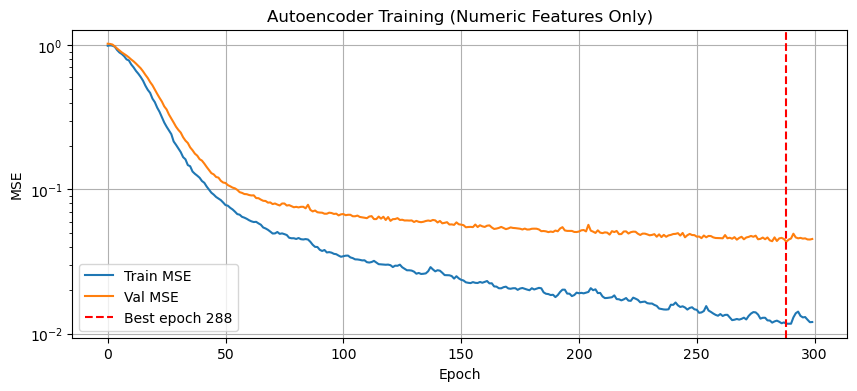

In [31]:
# CELL 8: Plot loss curves
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best epoch {best_epoch}')
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Autoencoder Training (Numeric Features Only)")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# CELL 9: Final reconstruction quality (clean & fair!)
model.eval()
all_orig = []
all_recon = []

with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(device)
        x_hat, _ = model(x)
        all_orig.append(x.cpu().numpy())
        all_recon.append(x_hat.cpu().numpy())

orig = np.concatenate(all_orig)
recon = np.concatenate(all_recon)

mse_total = mean_squared_error(orig, recon)
mse_per_feature = np.mean((orig - recon)**2, axis=0)

print(f"FINAL RESULTS (numeric features only)")
print(f"──────────────────────────────────────")
print(f"Validation MSE           : {mse_total:.8f}")
print(f"Mean per-feature MSE     : {mse_per_feature.mean():.8f}")
print(f"Std of per-feature MSE   : {mse_per_feature.std():.8f}")
print(f"Max per-feature MSE      : {mse_per_feature.max():.8f}")

FINAL RESULTS (numeric features only)
──────────────────────────────────────
Validation MSE           : 0.04344498
Mean per-feature MSE     : 0.04344498
Std of per-feature MSE   : 0.05608253
Max per-feature MSE      : 0.26174632


In [36]:
# # CELL 10: Visual sanity check on random samples
# model.eval()
# indices = np.random.choice(len(val_ds), 5, replace=False)

# with torch.no_grad():
#     for i in indices:
#         x, _ = val_ds[i]
#         x = x.unsqueeze(0).to(device)
#         x_hat, _ = model(x)
#         x = x.cpu().numpy().flatten()
#         x_hat = x_hat.cpu().numpy().flatten()
        
#         plt.figure(figsize=(12,3))
#         plt.plot(x, 'o-', label='Original', alpha=0.8)
#         plt.plot(x_hat, 's-', label='Reconstructed', alpha=0.8)
#         plt.title(f"Sample {i} — Reconstruction MSE = {mean_squared_error(x, x_hat):.6f}")
#         plt.legend()
#         plt.grid(True)
#         plt.show()

In [37]:
# # CELL 11: Save everything for later compression
# import joblib

# joblib.dump(preprocessor, "numeric_preprocessor.pkl")
# torch.save(model.encoder.state_dict(), "numeric_encoder_only.pth")

# print("Saved:")
# print("   → numeric_preprocessor.pkl")
# print("   → numeric_encoder_only.pth  (use this to compress new data)")

# print("\nTo compress new data later:")
# print("""
# new_df = pd.read_csv("new_file.csv")[numeric_cols]   # keep same columns!
# X_new = preprocessor.transform(new_df)
# X_tensor = torch.FloatTensor(X_new).to(device)
# model.encoder.eval()
# with torch.no_grad():
#     compressed = model.encoder(X_tensor).cpu().numpy()   # shape (n_samples, 32)
# """)

## Diagonostic

In [38]:
# Run this in a new cell – it will instantly reveal the culprits
model.eval()
with torch.no_grad():
    val_indices = val_ds.indices
    x_val = torch.FloatTensor(X[val_indices]).to(device)
    recon, _ = model(x_val)
    recon = recon.cpu().numpy()
    orig = X[val_indices]

per_feature_mse = np.mean((orig - recon)**2, axis=0)
worst_10 = np.argsort(per_feature_mse)[-10:][::-1]

print("Top 10 WORST reconstructed columns (these are killing your MSE)")
print("="*80)
for rank, idx in enumerate(worst_10, 1):
    col_name = numeric_cols[idx]
    mse = per_feature_mse[idx]
    uniqueness = df_numeric.iloc[val_indices, idx].nunique() / len(val_indices)
    print(f"{rank:2d}. {col_name:<35} MSE={mse:.6f}  uniqueness≈{uniqueness:.4f}")

Top 10 WORST reconstructed columns (these are killing your MSE)
 1. width                               MSE=0.261746  uniqueness≈0.5615
 2. item_weight                         MSE=0.241102  uniqueness≈0.3615
 3. reading_age_baby                    MSE=0.153695  uniqueness≈0.0154
 4. reading_age_null                    MSE=0.145012  uniqueness≈0.2692
 5. print_length                        MSE=0.134995  uniqueness≈0.4846
 6. height                              MSE=0.134594  uniqueness≈0.7000
 7. rating                              MSE=0.122747  uniqueness≈0.6000
 8. publisher_price_stern_sloan         MSE=0.118252  uniqueness≈0.0154
 9. publisher_world_of_eric_carle       MSE=0.106004  uniqueness≈0.0154
10. reading_age_preadolescence          MSE=0.097861  uniqueness≈0.6231
